## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df_metadata = pd.read_csv("./Chest_xray_Corona_Metadata.csv", index_col=0)
df_summary = pd.read_csv("./Chest_xray_Corona_dataset_Summary.csv", index_col=0)

In [4]:
df_metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
df_summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


In [6]:
def sel_image_plot(label='Normal', idx=0):
    
    """
    Input: Label of the image we want to select.
           Index of the image we want to select.
    Output: Plot of an image.
    """
    
    try:
        image_list = df_metadata[(df_metadata['Label'] == label) & (df_metadata['Dataset_type'] == 'TRAIN')]
        image_name= image_list['X_ray_image_name'].reset_index(drop=True)[idx]
        plt.imshow(plt.imread('./Coronahack-Chest-XRay-Dataset/train/' + image_name))
        plt.title('X-Ray of a pacient with label \'{0}\' from the train dataset'.format(label))
        plt.show()
        
    except KeyError:
        print('Index not in range.')

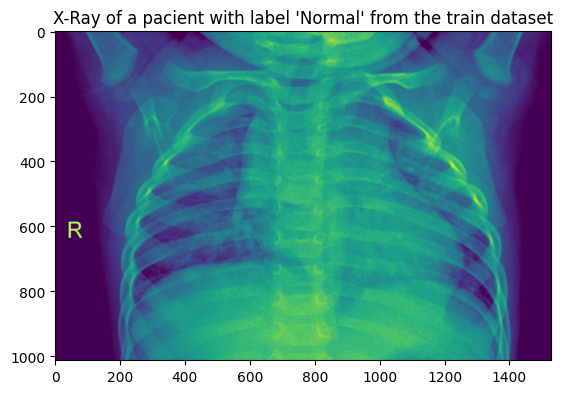

In [7]:
sel_image_plot(idx=0)

In [8]:
def sel_train_test(dataframe, train_test):
    
    """
    Inputs: Dataframe and a string (test or train).
    Outputs: Only the test or train examples in the dataframe.
    """
    
    dataframe_transformed = dataframe[dataframe['Dataset_type'] == train_test.upper()]
    
    return dataframe_transformed

In [9]:
def preprocess_img(img):
    return

In [10]:
IMAGE_DIM = 200

In [11]:
PATH = './Coronahack-Chest-XRay-Dataset/'
BATCH_SIZE = 8

# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split=0.1,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'train'),
                                                    x_col='X_ray_image_name',
                                                    y_col='Label',
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(IMAGE_DIM, IMAGE_DIM),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=1234,
                                                    subset='training', 
                                                    directory=PATH + 'train/')


val_generator = train_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'train'),
                                                    x_col='X_ray_image_name',
                                                    y_col='Label',
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(IMAGE_DIM, IMAGE_DIM),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=1234,
                                                    subset='validation', 
                                                    directory=PATH + 'train/')

test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)


test_generator = test_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'test'),
                                                  x_col='X_ray_image_name',
                                                  y_col='Label',
                                                  color_mode='rgb',
                                                  class_mode='binary',
                                                  target_size=(IMAGE_DIM, IMAGE_DIM),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False, 
                                                  directory=PATH + 'test/')

Found 4758 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [12]:
def model_inception():
    
    """
    Model InceptionV3.
    """
    
    inputs = tf.keras.layers.Input((IMAGE_DIM, IMAGE_DIM, 3))
    base_model = tf.keras.applications.Xception(input_tensor=inputs, include_top=False,
                                                 weights='imagenet',
                                                 input_shape=(IMAGE_DIM, IMAGE_DIM, 3))
    
    #x = base_model(inputs)
    
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

In [13]:
model = model_inception()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 99, 99, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 99, 99, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 99, 99, 32)           0         ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2_act (Activ  (None, 25, 25, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 25, 25, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 25, 25, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 13, 13, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 13, 13, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 13, 13, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 13, 13, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 13, 13, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 13, 13, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 13, 13, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 13, 13, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 13, 13, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 13, 13, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./ckpt/checkpoint.model_xception.keras',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True,
)

In [16]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=model_checkpoint_callback)

Epoch 1/5


I0000 00:00:1710873258.273513  203595 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


595/595 [==============================] - 74s 96ms/step - loss: 0.2143 - accuracy: 0.9176 - val_loss: 0.4927 - val_accuracy: 0.7708
Epoch 2/5
595/595 [==============================] - 53s 89ms/step - loss: 0.1173 - accuracy: 0.9506 - val_loss: 0.1593 - val_accuracy: 0.9318
Epoch 3/5
595/595 [==============================] - 52s 87ms/step - loss: 0.1030 - accuracy: 0.9607 - val_loss: 0.1846 - val_accuracy: 0.9394
Epoch 4/5
595/595 [==============================] - 57s 95ms/step - loss: 0.0837 - accuracy: 0.9685 - val_loss: 0.1309 - val_accuracy: 0.9621
Epoch 5/5
595/595 [==============================] - 54s 90ms/step - loss: 0.0661 - accuracy: 0.9769 - val_loss: 0.0732 - val_accuracy: 0.9697


In [17]:
model.load_weights('./ckpt/checkpoint.model_xception.keras')

Text(0, 0.5, 'Accuracy')

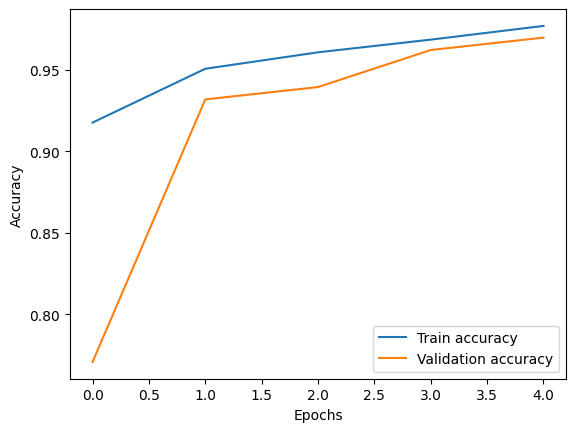

In [18]:
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

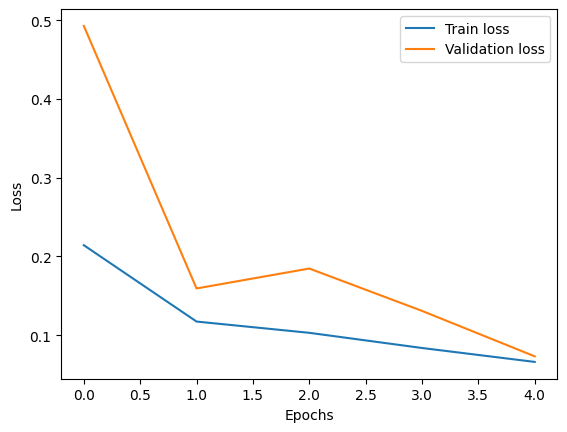

In [19]:
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [20]:
predictions = model.predict(test_generator)

78/78 [==============================] - 3s 29ms/step


In [21]:
predictions = (predictions > 0.5).astype(int).reshape(-1,)

In [22]:
true_labels = [False if x=="Normal" else True for x in sel_train_test(df_metadata, 'test')["Label"]]

In [23]:
print("Results on test set:")
print(classification_report(true_labels, predictions, target_names=["Normal", "Pnemonia"]))
print("ROC AUC score:   ",roc_auc_score(true_labels, predictions))
print("F1 score:", f1_score(true_labels, predictions))

Results on test set:
              precision    recall  f1-score   support

      Normal       0.94      0.57      0.71       234
    Pnemonia       0.79      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.83      0.81       624

ROC AUC score:    0.7739316239316238
F1 score: 0.8751431844215349


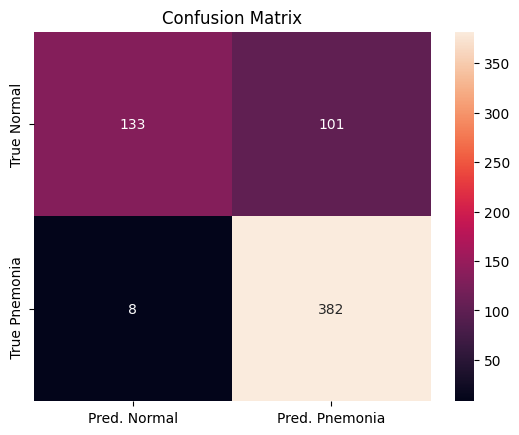

In [24]:
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix,
            xticklabels = ["Pred. Normal", "Pred. Pnemonia"],
            yticklabels =["True Normal", " True Pnemonia"],
            annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.show()

In [25]:
file_name_1 = df_metadata[(df_metadata['Label'] == 'Pnemonia') & 
            (df_metadata['Dataset_type'] == 'TEST')].sample(1).reset_index(drop=True).iloc[0, 0]

In [38]:
file_name_1 = 'person108_bacteria_507.jpeg'

In [39]:
img_saliency = cv2.imread('./Coronahack-Chest-XRay-Dataset/test/' + file_name_1)
img_saliency = cv2.resize(img_saliency, (IMAGE_DIM, IMAGE_DIM))
img_saliency = img_saliency / 255.
img_saliency_batched = np.expand_dims(img_saliency, axis=0)

In [40]:
model.predict(img_saliency_batched.astype(np.float32))

1/1 [==============================] - 0s 22ms/step


array([[0.9953401]], dtype=float32)

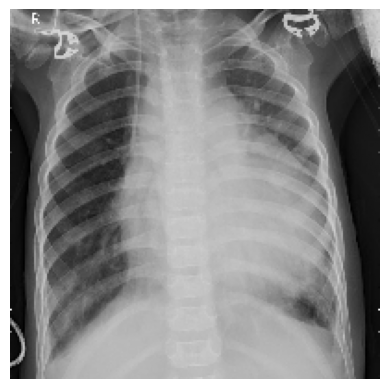

In [41]:
plt.imshow(img_saliency)
plt.axis('off')
plt.show()

In [42]:
class_index = 1
num_classes = 1

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * img_saliency_batched.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(img_saliency_batched, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.binary_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)

In [43]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

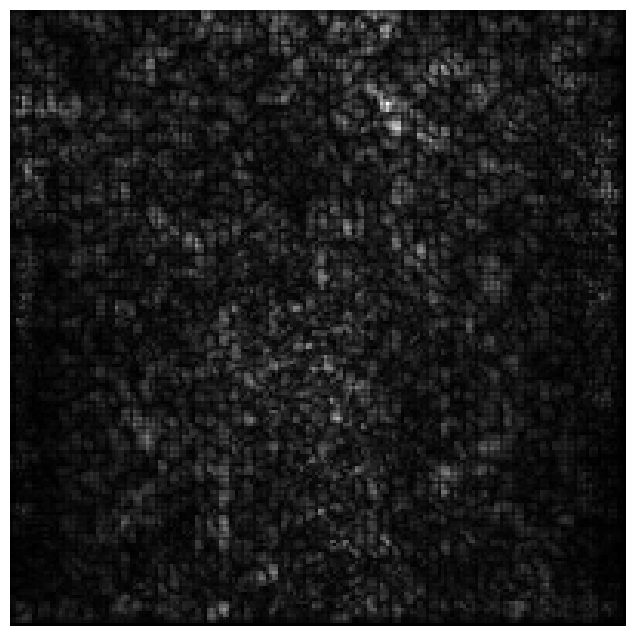

In [44]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

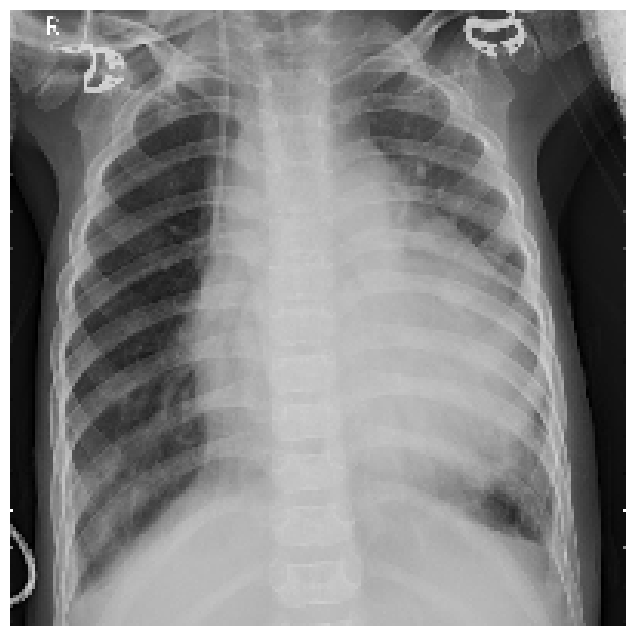

In [45]:
plt.figure(figsize=(8, 8))
plt.imshow(img_saliency)
plt.axis('off')
plt.show()

(200, 200, 3)


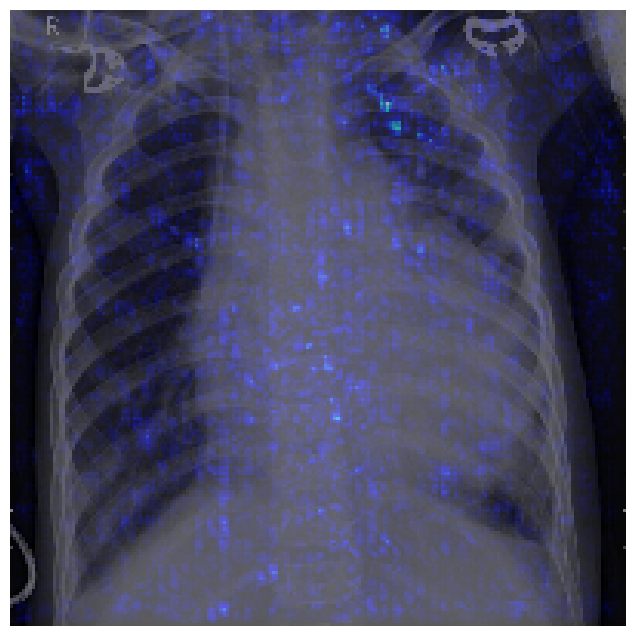

In [52]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img_saliency, 0.5, gradient_color, 0.5, 0.0)

print(super_imposed.shape)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.savefig('saliency.jpg', dpi=200)
plt.show()

## CAM model

In [35]:
model.layers[-4].name

'block14_sepconv2_act'

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array, training = False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Prepare image
img_array = cv2.imread('./Coronahack-Chest-XRay-Dataset/test/' + file_name_1)
img_array = cv2.resize(x, (IMAGE_DIM, IMAGE_DIM))
img_array = img_saliency / 255.
img_array = np.expand_dims(x, axis=0)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, model.layers[-4].name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

print(heatmap)


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.imshow(superimposed_img)


save_and_display_gradcam('./Coronahack-Chest-XRay-Dataset/test/' + file_name_1, heatmap)


1/1 [==============================] - 0s 23ms/step


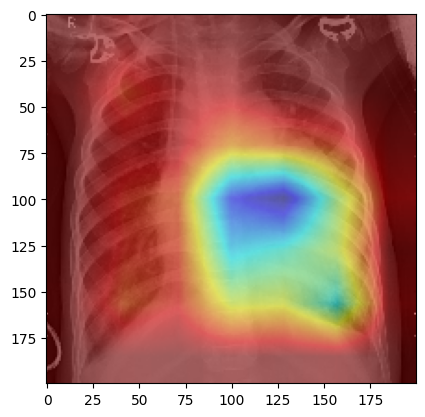

In [47]:
def gradCAM(orig, res=IMAGE_DIM):

    x = cv2.imread('./Coronahack-Chest-XRay-Dataset/test/' + orig)
    x = cv2.resize(x, (IMAGE_DIM, IMAGE_DIM))
    x = img_saliency / 255.
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    #print(decode_predictions(preds)[0][0][1]) # prints the class of image

    with tf.GradientTape() as tape:
        last_conv_layer = model.layers[-4]
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, tf.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    #print(last_conv_layer)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))

    img = cv2.imread('./Coronahack-Chest-XRay-Dataset/test/' + orig)
    img = cv2.resize(img, (IMAGE_DIM, IMAGE_DIM))
    
    heatmap = cv2.resize(heatmap, (img.shape[0], img.shape[1]))

    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    
    #plt.imshow(heatmap)
    #print(heatmap)

    img = cv2.addWeighted(heatmap, 0.5, img, 0.5, 0)
    
    #print(img)

    plt.imshow(img)

gradCAM(file_name_1)

In [37]:
model